In [54]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

In [55]:
class State(TypedDict):
    hello: str
    a: bool


graph_builder = StateGraph(State)

In [ ]:
def node_one(state: State):
    print("node_one", state)
    return {
        "hello": "from node one.",
        "a": True,
    }


def node_two(state: State):
    print("node_two", state)
    return {"hello": "from node two."}


def node_three(state: State):
    print("node_three", state)
    return {"hello": "from node three."}

In [57]:
graph_builder.add_node("node_one", node_one)
graph_builder.add_node("node_two", node_two)
graph_builder.add_node("node_three", node_three)

graph_builder.add_edge(START, "node_one")
graph_builder.add_edge("node_one", "node_two")
graph_builder.add_edge("node_two", "node_three")
graph_builder.add_edge("node_three", END)

In [58]:
graph = graph_builder.compile()

result = graph.invoke(
    {
        "hello": "world",
    },
)

node_one {'hello': 'world'}
node_two {'hello': 'from node one.', 'a': True}
node_three {'hello': 'from node two.', 'a': True}


In [59]:
result

{'hello': 'from node three.', 'a': True}

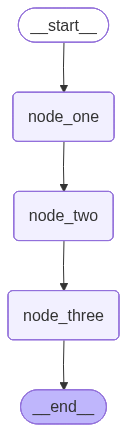

In [60]:
graph